In [1]:
import matplotlib 
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

# Defining the road items
- Return matplotlib rectangle plot  objects
- Also returns coordinates of the object

In [2]:
def road_item(name, item_x, item_y, item_width, item_length, item_color = "black", speed_x = 0, speed_y = 0):
    plot_obj = matplotlib.patches.Rectangle((item_x + speed_x, item_y + speed_y),
                                            item_width,
                                            item_length,
                                            color = item_color)
    item_coords = \
    {name : {
            "blx": item_x + speed_x,
            "bly": item_y + speed_y,
            "brx": item_x + speed_x + item_width,
            "bry": item_y + speed_y,
            "tlx": item_x + speed_x,
            "tly": item_y + speed_y + item_length,
            "trx": item_x + speed_x + item_width,
            "try": item_y + speed_y + item_length
            }}
    return plot_obj, item_coords


# Reading and initialize the environment obstacles file
Users can modify this file to define the vehicle initial coordinates, static obstacles, non-static obstacles, speed and direction of non-static obstacles. Guidelines:
- "vehicle" 20 0 20 30 "green" : 1st argument is the name of the road item. In this case it is the vehicle. 2nd and 3rd arguments are the bottom left abscissa and bottom left ordinate of the road item respectively. 4th and 5th arguments are horizontal x-axis and vertical y-axis lengths of the item. Last argument is te colour of the item.

- "obstacle_right4" 80 1000 20 20 : In this case the item is an obstacle, named as obstacle_right4. All static obstacles MUST start with "obstacle_right", followed by an item number or text in any format.

- "obstacle_moving2" 0 550 30 50 "red" 0.2 0 : In this case the item is a non-static obstacle, named as obstacle_moving2. All static obstacles MUST start with "obstacle_moving", followed by an item number or text in any format. The 7th and 8th arguments, "0.2" and "0" are the horizontal x-axis and vertical y-axis speeds of the moving obstacle. Use "-" negative signs for the obstacle to move in negative x or y direction.

In [3]:
with open("environment_obstacles.txt", "r") as file:
    arguments = [line.strip().split(" ") for line in file if line.strip()]

arguments = [[eval(i) for i in arguments_] for arguments_ in arguments]

# Create variables dynamically for the first time
for args in arguments:
    # for arg in args:
    globals()[args[0]], globals()[args[0] + "_coords"] = road_item(*args)    

In [4]:
obstacle_coords_list_ = [var for var in dir() if not var.startswith("_") and var[-7:] == "_coords" and var[:8] == "obstacle"]
obstacle_coords_list_ = [eval(name) for name in obstacle_coords_list_]
obstacle_coords_list = {k: v for d in obstacle_coords_list_ for k, v in d.items()}
# obstacle_coords_list

In [5]:
# Get the first obstacle in path

first_obstacle = list(obstacle_coords_list.keys())[0]
v_bly = obstacle_coords_list[first_obstacle]["bly"]

for k, v in obstacle_coords_list.items():
    if v_bly >= v["bly"]:
        first_obstacle = k
        v_bly = v["bly"]

first_obstacle, v_bly

('obstacle_left1', 50)

# Define the forward speed of the vehicle

In [6]:
VEHICLE_X = arguments[0][1]
VEHICLE_Y = arguments[0][2]

VEHICLE_SPEED_X = 0 # By default the horizontal steering speed is zero
VEHICLE_SPEED_Y = 15 # USER INPUT- Mention the forward speed of the vehicle

X_MIN = 0
X_MAX = 100
Y_MIN = 0
Y_MAX = 1000

# Function to recreate the road items with the updated position of the vehicle and moving obstacles

In [7]:
def recreate_items(VEHICLE_X, VEHICLE_Y, speed_counter):
    # Create variables dynamically
    for args in arguments:
        if args[0] == "vehicle":
            globals()["vehicle"], globals()["vehicle_coords"] = road_item("vehicle", VEHICLE_X, VEHICLE_Y, args[3], args[4], args[5])
        elif args[0][:15] == "obstacle_moving":
            globals()[args[0]], globals()[args[0] + "_coords"] = road_item(args[0], args[1], args[2], args[3], args[4], args[5], speed_x = args[6] * speed_counter, speed_y = args[7] * speed_counter)
        else:
            globals()[args[0]], globals()[args[0] + "_coords"] = road_item(*args)


# Start the simulation

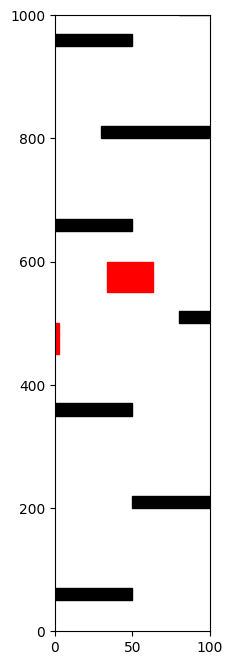

In [8]:
# Move to hitting the back of next obstacle
# while obstacle_coords_list[first_obstacle]["bry"] > vehicle_coords["vehicle"]["tly"]:

speed_counter = 1
while len(obstacle_coords_list) != 0:

    # Horizontal Pass check
    if (obstacle_coords_list[first_obstacle]["brx"] <= vehicle_coords["vehicle"]["tlx"]) or (obstacle_coords_list[first_obstacle]["blx"] >= vehicle_coords["vehicle"]["trx"]):

        # Reset horizontal movement to zero
        VEHICLE_SPEED_X = 0

        # Vertical Pass check
        if obstacle_coords_list[first_obstacle]["try"] < vehicle_coords["vehicle"]["tly"]:

            # Calculate next obstacle
            del obstacle_coords_list[first_obstacle]

            if len(obstacle_coords_list) != 0:
                first_obstacle = list(obstacle_coords_list.keys())[0]
                v_bly = obstacle_coords_list[first_obstacle]["bly"]

                for k, v in obstacle_coords_list.items():
                    if v_bly >= v["bly"]:
                        first_obstacle = k
                        v_bly = v["bly"]
            else:
                continue

    # If horizontal pass does not check and vehicle need to steer towards right or left
    elif VEHICLE_SPEED_X == 0:

        # Calculate distance to steer
        dist_tosteer_right = obstacle_coords_list[first_obstacle]["brx"] - vehicle_coords["vehicle"]["tlx"]
        dist_tosteer_left = obstacle_coords_list[first_obstacle]["blx"] - vehicle_coords["vehicle"]["trx"]
        dist_gap_left = obstacle_coords_list[first_obstacle]["blx"] - X_MIN
        dist_gap_right = X_MAX - obstacle_coords_list[first_obstacle]["brx"]

        # Decide which direction to steer - left or right
        if (dist_gap_left == 0) & (dist_gap_right == 0):
            break
        elif dist_gap_left >= dist_gap_right:
            VEHICLE_SPEED_X = dist_tosteer_left / ((obstacle_coords_list[first_obstacle]["bry"] - vehicle_coords["vehicle"]["tly"]) / VEHICLE_SPEED_Y)
        else:
            VEHICLE_SPEED_X = dist_tosteer_right / ((obstacle_coords_list[first_obstacle]["bry"] - vehicle_coords["vehicle"]["tly"]) / VEHICLE_SPEED_Y)
        
        if VEHICLE_SPEED_X > 0:
            VEHICLE_SPEED_X = np.ceil(VEHICLE_SPEED_X)
        else:
            VEHICLE_SPEED_X = np.floor(VEHICLE_SPEED_X)

    fig = plt.figure(figsize = (2, 8))
    ax = fig.add_subplot(111)

    VEHICLE_X = VEHICLE_X + VEHICLE_SPEED_X
    VEHICLE_Y = VEHICLE_Y + VEHICLE_SPEED_Y

    recreate_items(VEHICLE_X, VEHICLE_Y, speed_counter)
    speed_counter += 1

    obstacle_moving_remaining_list = [s for s in obstacle_coords_list.keys() if "obstacle_moving" in s]
    for obstacle_moving_remaining in obstacle_moving_remaining_list:
        obstacle_coords_list.update(eval(obstacle_moving_remaining + "_coords"))

    for args in arguments:
        ax.add_patch(eval(args[0]))

    plt.xlim([X_MIN, X_MAX]) 
    plt.ylim([Y_MIN, Y_MAX])

    plt.show()
    plt.pause(0.1)
    clear_output(wait=True)
